[DNN tutorial](https://pythonprogramming.net/train-test-tensorflow-deep-learning-tutorial/?completed=/preprocessing-tensorflow-deep-learning-tutorial/)

[markdown syntax](https://www.markdownguide.org/basic-syntax/)

[slides](https://docs.google.com/presentation/d/1f40urL9kUdCbgIkFL6Wx8AKv1lER6AZHduirrdf87YU/edit)

# TO DO:
- nicely display what model does on a backdoored image
- actual backoor identification
- fix bug with cropping (during count >= 4000)
- figure out how to do one-hot encoding
    - [stack overflow](https://stackoverflow.com/questions/43330208/shaping-input-labels-for-tensorflow)
- clean up code
- API :((

# Loading Data

In [1]:
import os
import random
import skimage.data
import skimage.transform
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

import display #extra functions
import utils

In [1]:
# Allow image embeding in notebook
%matplotlib inline

categories = {'warning':0, 'speedlimit':1, 'stop':2,
             0:'warning', 1:'speedlimt', 2:'stop'}
num_backdoored = 0

def load_data(data_dir, ann_dir):
    #returns a tuple of the relevant images and the relevant labels
    labels, images = [], []
    x1, x2, y1, y2 = 0, 0, 0, 0
    count = 0
    global num_backdoored
    with open(data_dir) as imset:
        for cur_im in imset:
            if cur_im.endswith("\n"):
                cur_im = cur_im[:-1] 
            with open(os.path.join(ann_dir, cur_im + ".txt")) as annotation:
                for anno in annotation:
                    if count >= 130:
                        break
                    label,x1,y1,x2,y2,clean = anno.split(',')
                    ##################
                    # making sure testing data only has backdoored images
                    if "test_targ_ysq_backdoor.txt" in data_dir:
                        if 'clean' in clean or 'speedlimit' not in label:
                            break
                    ##################
                    image = skimage.data.imread(os.path.join("Images", cur_im+".png"))
                    if 'clean' not in clean:
                        num_backdoored += 1
                    try:
                        image = utils.crop(image, x1, y1, x2, y2)
                    except:
                        break
                    images.append(utils.process_image(image))
                    labels.append(categories[label])
                    count += 1
        return images, labels

train_data_dir = os.path.join("ImageSets", "test_ysq.txt")
test_data_dir = os.path.join("ImageSets", "test_targ_ysg_backdoor.txt")
anno_dir = "Annotations"

images, labels = load_data(train_data_dir, anno_dir)

################## SANITY CHECKS ########################
print("Sanity Check:")
#print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))
unique_labels = set(labels)
for label in unique_labels:
    print("label:", label, "count:", labels.count(label))
print("number of backdoored images:", num_backdoored)
#########################################################

display.display_images_and_labels(images, labels)

KeyboardInterrupt: 

# Creating DNN

In [3]:
n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500
n_classes = 3
batch_size = 100

# Flatten input from: [None, height, width, channels]
# To: [None, height * width * channels] == [None, 3072]
x = tf.placeholder('float', [None, 3072], name='x')
y = tf.placeholder('int64', name='y')

In [4]:
def neural_network_model(data):
    hidden_1_layer = {'weights':tf.Variable(tf.random_normal([3072, n_nodes_hl1])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}

    hidden_3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl3]))}

    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                    'biases':tf.Variable(tf.random_normal([n_classes]))}
    
    l1 = tf.add(tf.matmul(data,hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)

    output = tf.matmul(l3,output_layer['weights']) + output_layer['biases']

    return output

def next_batch(num, data, labels):
    '''
    Return 'num' random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [5]:
prediction = neural_network_model(x)
cost = tf.reduce_mean( tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, labels=tf.squeeze(y)) )
      
correct = tf.equal(tf.argmax(prediction, 1), y)        
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
    
optimizer = tf.train.AdamOptimizer().minimize(cost)
    
hm_epochs = 30

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(hm_epochs):
    epoch_loss = 0
    for _ in range(int(len(images)/batch_size)):
        epoch_x, epoch_y = next_batch(batch_size, images, labels)
        _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
        epoch_loss += c

    print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)
          
#correct = tf.equal(tf.argmax(prediction, 1), y)        
#accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        
test_images, test_labels = load_data(train_data_dir, anno_dir)

print('Accuracy:',accuracy.eval({x:test_images, y:test_labels}, sess))

Epoch 0 completed out of 30 loss: 385711.8212890625
Epoch 1 completed out of 30 loss: 94864.36767578125
Epoch 2 completed out of 30 loss: 50672.324951171875
Epoch 3 completed out of 30 loss: 40010.46911621094
Epoch 4 completed out of 30 loss: 34884.54650878906
Epoch 5 completed out of 30 loss: 25073.258056640625
Epoch 6 completed out of 30 loss: 21368.417724609375
Epoch 7 completed out of 30 loss: 14782.244995117188
Epoch 8 completed out of 30 loss: 16088.719909667969
Epoch 9 completed out of 30 loss: 13862.089569091797
Epoch 10 completed out of 30 loss: 11857.473754882812
Epoch 11 completed out of 30 loss: 10472.626983642578
Epoch 12 completed out of 30 loss: 6068.048431396484
Epoch 13 completed out of 30 loss: 6855.853118896484
Epoch 14 completed out of 30 loss: 6354.385162353516
Epoch 15 completed out of 30 loss: 6932.936981201172
Epoch 16 completed out of 30 loss: 6457.6929931640625
Epoch 17 completed out of 30 loss: 5592.0069580078125
Epoch 18 completed out of 30 loss: 6401.848800

In [6]:
##################### SAVING MODEL #######################
saver = tf.train.Saver()
save_path = saver.save(sess, "/tmp/model.ckpt")
print("Model saved in path: %s" % save_path)
#########################################################

Model saved in path: /tmp/model.ckpt


## Identifying Backdoor

[paper](http://people.cs.uchicago.edu/~ravenben/publications/pdf/backdoor-sp19.pdf)

[more useful paper](https://arxiv.org/pdf/1608.04644.pdf?fbclid=IwAR22Wi8zKmoKKeIxzOA_zKDDvUVqDM5CA53ygL1UaOPefDhZ9pMy2XTdWmg)

In [7]:
# Preprocessing

# Representative images:
#     stop: Images/0000082.png
#     speedlimit: Images/0000137.png
#     warning: Images/0000169.png
#     dirty stop: targeted_attack\stop-speedlimit-ysq\0201244.png

rep_stop = skimage.data.imread(os.path.join("Images", "0000082.png"))
max_h, max_w = rep_stop.shape[0], rep_stop.shape[1]

with open(os.path.join(anno_dir, "0000082.txt")) as annotation:
    for anno in annotation:
        if "stop" in anno:
            label,x1,y1,x2,y2,clean = anno.split(',')
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
rep_stop = skimage.util.crop(rep_stop,((y1, max_h - y2),(x1,max_w - x2),(0,0)), copy=False)
rep_stop = utils.process_image(rep_stop)

########################################################

bad_stop = skimage.data.imread(os.path.join("targeted_attack\stop-speedlimit-ysq", "0201244.png"))
max_h, max_w = bad_stop.shape[0], bad_stop.shape[1]

with open(os.path.join(anno_dir, "0201244.txt")) as annotation:
    for anno in annotation:
        if "stop" in anno:
            label,x1,y1,x2,y2,clean = anno.split(',')
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
bad_stop = skimage.util.crop(bad_stop,((y1, max_h - y2),(x1,max_w - x2),(0,0)), copy=False)
bad_stop = utils.process_image(bad_stop)

################## SANITY CHECKS ########################
# correctly labels a stop as stop
# print('Accuracy:',accuracy.eval({x:rep_stop, y:[2]}))
#########################################################

In [8]:
def load_clean_stops(data_dir, ann_dir):
    #returns a tuple of the relevant images and the relevant labels
    labels, images = [], []
    x1, x2, y1, y2 = 0, 0, 0, 0
    count = 0
    global num_backdoored
    with open(data_dir) as imset:
        for cur_im in imset:
            if cur_im.endswith("\n"):
                cur_im = cur_im[:-1] 
            with open(os.path.join(ann_dir, cur_im + ".txt")) as annotation:
                for anno in annotation:
                    if count >= 1300:
                        break
                    label,x1,y1,x2,y2,clean = anno.split(',')
                    if 'stop' not in label or 'clean' not in clean:
                        break
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    image = skimage.data.imread(os.path.join("Images", cur_im+".png"))
                    max_h, max_w = image.shape[0], image.shape[1]
                    try:
                        image = skimage.util.crop(image,((y1, max_h - y2),(x1,max_w - x2),(0,0)), copy=False)
                    except:
                        break
                    images.append(utils.process_image(image))
                    labels.append(categories[label])
                    #labels.append(2)
                    count += 1
        return images, labels

In [9]:
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")
print("Model restored.")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Model restored.


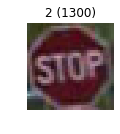

In [10]:
train_data_dir = os.path.join("ImageSets", "train_targ_ysq.txt")
clean_stops, clean_stops_labels = load_clean_stops(train_data_dir, anno_dir)
display.display_images_and_labels(clean_stops, clean_stops_labels)

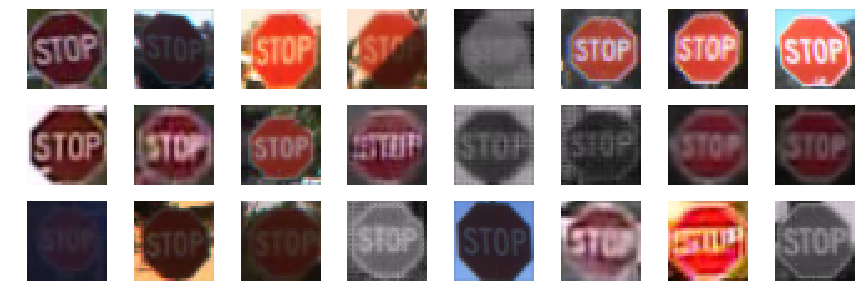

In [29]:
display.display_label_images(clean_stops, 2, clean_stops_labels)

In [12]:
prediction = neural_network_model(x)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
bloop = sess.run([prediction], feed_dict={x:clean_stops})

(array([351.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 949.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

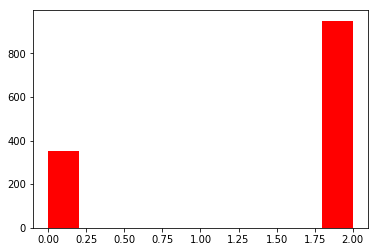

In [27]:
plt.hist(np.argmax(bloop[0], axis=1),color='red')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


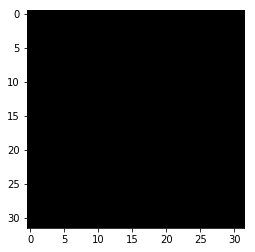

Epoch 0 completed out of 30 loss: 2031310.7890625


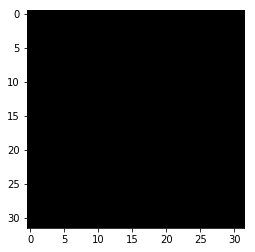

Epoch 1 completed out of 30 loss: 586195.2412109375


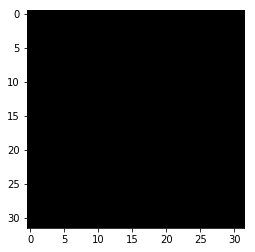

Epoch 2 completed out of 30 loss: 28183.334869384766


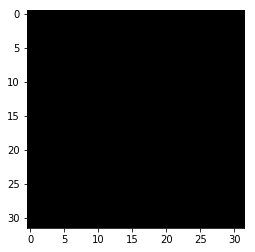

Epoch 3 completed out of 30 loss: 1995.961556059774


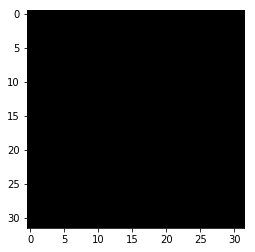

Epoch 4 completed out of 30 loss: 1266.9314263968845


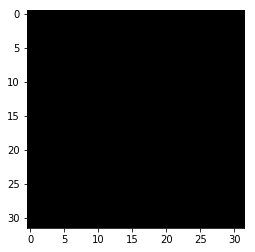

Epoch 5 completed out of 30 loss: 175.296917222091


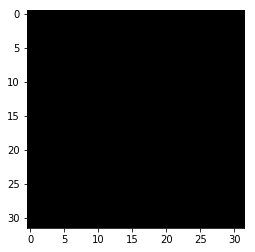

Epoch 6 completed out of 30 loss: 679.6772798782913


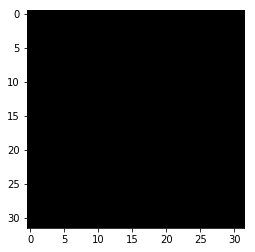

Epoch 7 completed out of 30 loss: 257.1673527130042


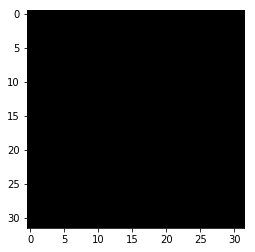

Epoch 8 completed out of 30 loss: 262.50686040509026


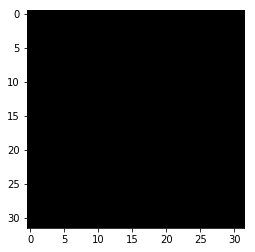

Epoch 9 completed out of 30 loss: 1125.4361315789283


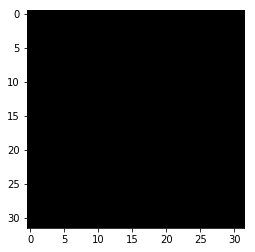

Epoch 10 completed out of 30 loss: 48.00006855610991


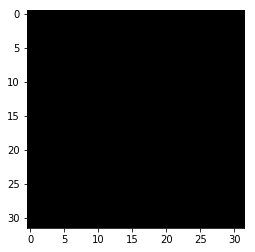

Epoch 11 completed out of 30 loss: 182.69338569964748


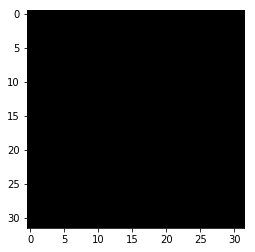

Epoch 12 completed out of 30 loss: 88.8460050613503


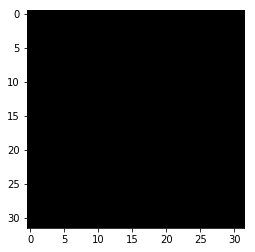

Epoch 13 completed out of 30 loss: 120.06739488436142


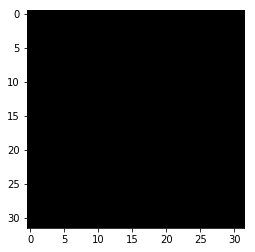

Epoch 14 completed out of 30 loss: 249.05206632538466


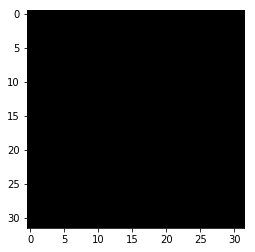

Epoch 15 completed out of 30 loss: 258.11844139220193


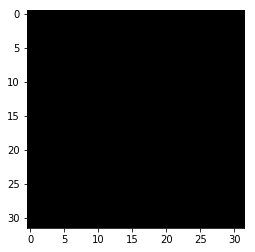

Epoch 16 completed out of 30 loss: 252.68104005686473


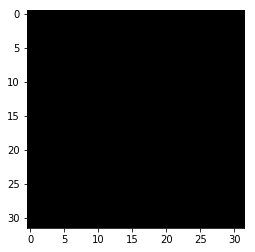

Epoch 17 completed out of 30 loss: 212.4461962262867


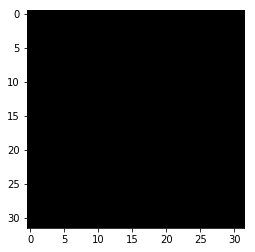

Epoch 18 completed out of 30 loss: 317.711288834922


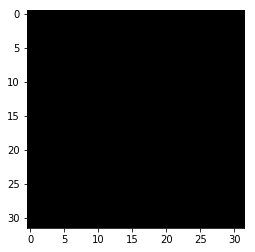

Epoch 19 completed out of 30 loss: 28.98686111473944


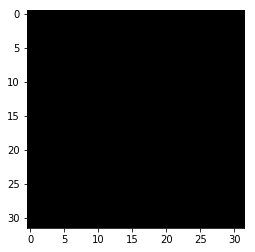

Epoch 20 completed out of 30 loss: 138.59793385514058


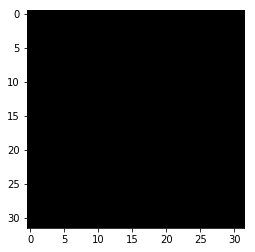

Epoch 21 completed out of 30 loss: 255.9271179701318


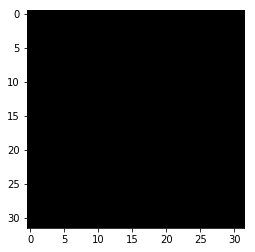

Epoch 22 completed out of 30 loss: 109.30247438774677


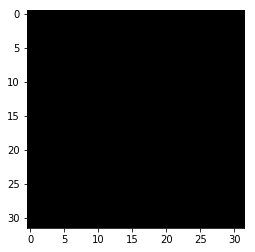

Epoch 23 completed out of 30 loss: 148.3730512924958


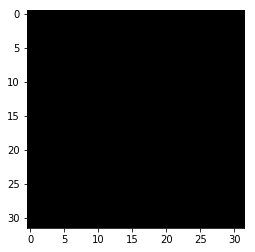

Epoch 24 completed out of 30 loss: 101.31436529709026


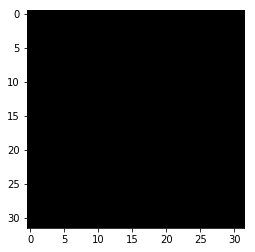

Epoch 25 completed out of 30 loss: 18.065883954637684


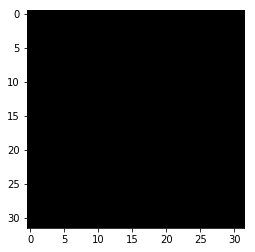

Epoch 26 completed out of 30 loss: 82.46007160912268


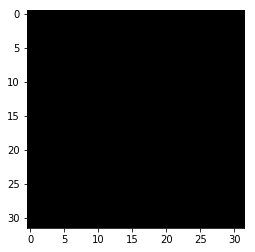

Epoch 27 completed out of 30 loss: 77.9357193664764


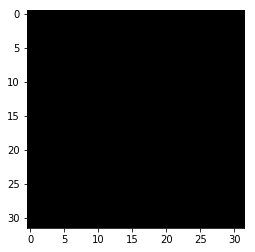

Epoch 28 completed out of 30 loss: 46.385234528861474


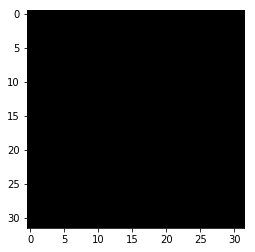

Epoch 29 completed out of 30 loss: 6.151220187079161


In [14]:
n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500
n_classes = 3
batch_size = 100
    
trigger = tf.Variable(tf.zeros([1, 3072]),name='trigger')
mask = tf.Variable(tf.zeros([1, 3072]), dtype=tf.float32, name='mask')
image = tf.placeholder('float', [batch_size, 3072], name='image')

x2 = tf.math.multiply((1-mask), image) + tf.ones([image.shape[0], 1])*tf.math.multiply(mask, trigger) #tainted
yt = tf.ones([image.shape[0], 1], dtype="int32")*tf.constant([0,1,0])

prediction = neural_network_model(x2)

####################################################################################

cost2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(\
                                logits=prediction, labels=yt,name='iamdying')) + 0.0001*tf.norm(mask, ord=1)
optimizer2 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost2)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

hm_epochs = 30
for epoch in range(hm_epochs):
    epoch_loss = 0
    for _ in range(int(len(clean_stops)/batch_size)):
        epoch_x, epoch_y = next_batch(batch_size, clean_stops, clean_stops_labels)
        _, c = sess.run([optimizer2, cost2], feed_dict={image:epoch_x, x: epoch_x, y: epoch_y})
        epoch_loss += c
    view_mask = sess.run(mask)
    view_trigger = sess.run(trigger)
    view_trigger = np.multiply(view_mask, view_trigger)
    view_trigger = utils.unflatten(view_trigger)
    plt.imshow(view_trigger)
    plt.show()

    print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)
    
    trigger = tf.clip_by_value(trigger, clip_value_min=0, clip_value_max=255)
    mask = tf.clip_by_value(mask, clip_value_min=0., clip_value_max=1.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


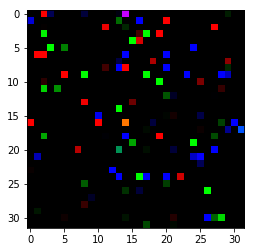

In [15]:
view_mask = sess.run(mask)
view_trigger = sess.run(trigger)

view_trigger = np.multiply(view_mask, view_trigger)

view_trigger = utils.unflatten(view_trigger)

plt.imshow(view_trigger*10e5)

In [88]:
len(clean_stops)

1300

In [53]:
view_mask.shape

(1, 3072)

In [52]:
view_trigger

array([[[7.6965529e-07, 0.0000000e+00, 5.9901708e-07],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.1015806e-06, 3.4447994e-06]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 6.4838787e-07, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.7767148e-06, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 2.3289367e-06],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00

In [ ]:
print(sum(view_trigger))

#### NOTES:
- a **deep** neural network has more than 2 layers
- **logit** is a function that maps probabilities \[0, 1\] to \[-inf, +inf\].
- **softmax** is a function that maps \[-inf, +inf\] to \[0, 1\] similar as Sigmoid. 
    - softmax also normalizes the sum of the values(output vector) to be 1.
- **tensorflow "with logit"** means that you are applying a softmax function to logit numbers to normalize it. 
    - the input_vector/logit is not normalized and can scale from \[-inf, inf\].
- tensorflow **graph** vs **session**:
    - a **graph** defines the computation. It doesn’t compute anything, it doesn’t hold any values, it just defines the operations that you specified in your code.
    - a **session** allows to execute graphs or part of graphs. It allocates resources (on one or more machines) for that and holds the actual values of intermediate results and variables.
    - [source](https://danijar.com/what-is-a-tensorflow-session/)
- **one_hot encoding** should be used with categorical data
    - mapping labels to integers may cause unwanted side effects (1<2<3 etc.)
    - [stack exchange](https://datascience.stackexchange.com/questions/30215/what-is-one-hot-encoding-in-tensorflow?rq=1)
- **tf.squeeze()**: given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
- **cross-entropy**: or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label.
- purpose of bias: bias is a value that is added to our sums, before being passed through the activation function 
    - purpose of the bias here is mainly to handle for scenarios where all neurons fired a 0 into the layer 
    - bias makes it possible that a neuron still fires out of that layer
    - a bias is as unique, and also needs to be optimized